In [1]:
import os
import numpy as np
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BRICK = '015823m04663'
outdir = os.path.join(os.environ.get('SCRATCH'), 'SGA2024-bricks', BRICK)
outdir

'/pscratch/sd/i/ioannis/SGA2024-bricks/015823m04663'

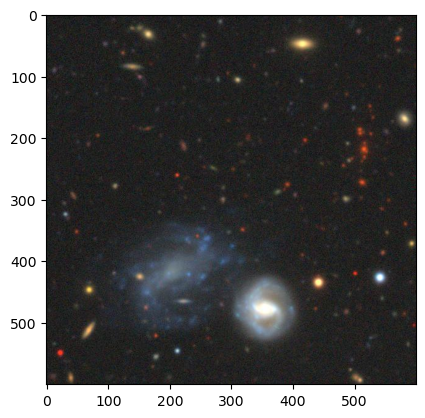

In [4]:
img = plt.imread(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image.jpg')
plt.imshow(img)

/tmp/ipykernel_1346077/1060232688.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(rimg), origin='lower')


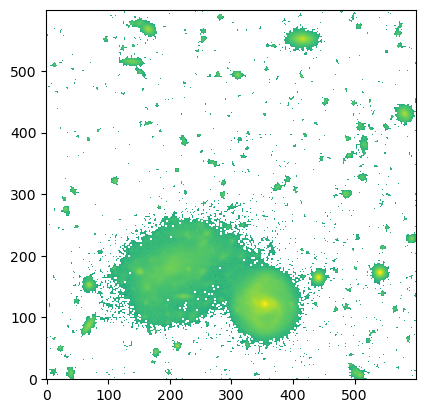

In [5]:
rimg = fitsio.read(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image-r.fits.fz')
plt.imshow(np.log10(rimg), origin='lower')

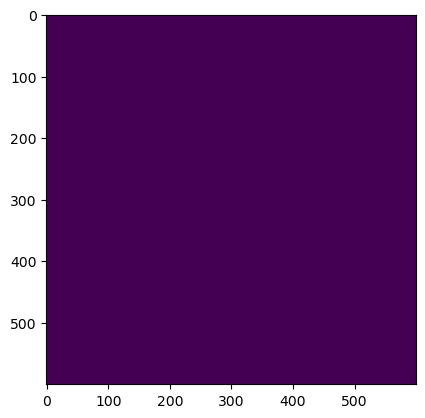

In [6]:
mask = fitsio.read(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-maskbits.fits.fz')
plt.imshow(mask)

ra,dec,ref_cat,ref_id,mag,istycho,isgaia,islargegalaxy,iscluster,isbright,ismedium,freezeparams,pointsource,donotfit,in_bounds,decam_mag_g,decam_mag_r,decam_mag_i,decam_mag_z,zguess,mask_mag,radius,keep_radius,radius_pix,ibx,iby,ref_epoch,pmra,pmdec,parallax,ra_ivar,dec_ivar,pmra_ivar,pmdec_ivar,parallax_ivar,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_n_obs,astrometric_excess_noise,astrometric_excess_noise_sig,duplicated_source,phot_bp_rp_excess_factor,astrometric_sigma5d_max,astrometric_params_solved
float64,float64,str2,int64,float32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,bool,float32,float32,uint8
15.76005061630907,-4.8370552538073985,GE,2525049829240950144,5.0785265,True,True,False,False,True,True,False,True,False,False,5.8229094,4.924919,4.6499987,4.513409,4.513409,5.0785265,0.08319182,0.33276728,1144,1164,-2092,2016.0,-116.58516,-102.60755,9.508311,2494790300000000.0,5318064000000000.0,109.23901,124.45834,137.97176,5.0785265,5.6536,4.3491483,1713.1199,1504.7421,322.43893,262,0.48428303,282.0684,False,1.2510798,0.15741968,95
15.799815800991192,-4.629510667381685,GE,2525073159502950272,14.17785,False,True,False,False,False,True,False,True,False,False,14.513109,14.095784,13.988249,13.965939,13.965939,14.17785,0.0039968817,0.015987527,55,620,760,2016.0,7.932692,-0.66877645,1.2706335,2.4745145e+16,5.0897342e+16,1801.7802,1550.3191,1297.8739,14.17785,14.499743,13.684232,4717.419,1074.5609,979.2078,296,0.0,0.0,False,1.2023752,0.041104306,31
15.805552788266539,-4.672243895594406,GE,2525069998407021312,17.163004,False,True,False,False,False,False,False,True,False,True,17.680916,17.037405,16.851118,16.773243,16.773243,17.163004,0.0014764405,0.005905762,21,541,172,2016.0,13.739943,-0.9664553,0.4639768,2550276400000000.0,4566566000000000.0,136.58972,126.29753,137.9839,17.163004,17.610178,16.548634,1184.9962,98.96174,183.01787,321,0.118182756,0.42135018,False,1.2216384,0.14476044,31
15.812834082776737,-4.672837478567456,GE,2525069998407021696,17.495584,False,True,False,False,False,False,False,True,False,True,18.774326,17.416992,16.810377,16.531963,16.531963,17.495584,0.0013213865,0.005285546,19,441,164,2016.0,-4.850088,-11.788209,0.82817787,1791273300000000.0,3476503300000000.0,93.95486,88.71517,98.51978,17.495584,18.388046,16.544672,1064.6107,71.55858,206.26604,312,0.0,0.0,False,1.3293692,0.17274249,31
15.805174039902397,-4.688271570704278,GE,2525069753593641728,18.727879,False,True,False,False,False,False,False,False,False,False,19.04259,18.651926,18.554926,18.539263,18.539263,18.727879,0.00087596837,0.0035038735,13,546,-48,2016.0,11.617759,-12.772981,0.050704677,439187100000000.0,753778840000000.0,23.107977,20.548859,24.04258,18.727879,19.082396,18.29859,553.33746,43.44676,46.532948,321,0.2503391,0.3037982,False,1.1482627,0.3562025,31
15.8192010510771,-4.675963374402324,GE,2525069792248591616,19.056929,False,True,False,False,False,False,False,False,False,True,19.787436,18.904224,18.635036,18.501835,18.501835,19.056929,0.00078489917,0.0031395967,11,354,121,2016.0,0.0,0.0,0.0,13401133000000.0,36664995000000.0,0.0,0.0,0.0,19.056929,17.078438,15.78777,120.32316,87.003136,266.75903,269,6.113514,50.389194,False,13.034284,1.8050677,3
15.82954514259039,-4.680914116023231,GE,2525069723529202048,20.559723,False,True,False,False,False,False,False,False,False,True,20.996702,20.451025,20.297174,20.242922,20.242922,20.559723,0.00047542376,0.001901695,7,213,53,2016.0,1.1264869,-6.5655255,0.25716403,27198833000000.0,25693813000000.0,0.82009596,0.42566913,1.5238757,20.559723,20.826082,19.866005,116.60602,8.664745,11.721791,189,0.0,0.0,False,1.3648909,2.4856668,31
15.814724408068043,-4.644682103381343,GE,252507016591053

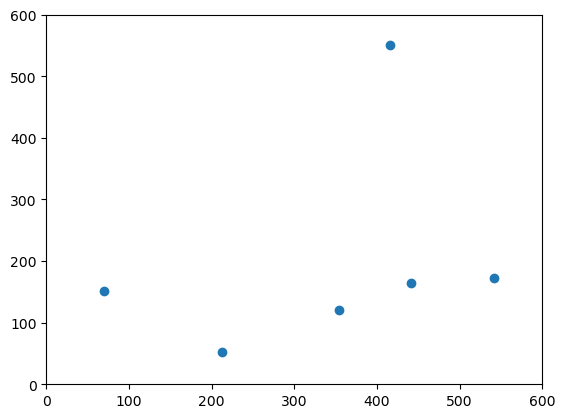

In [7]:
f'{outdir}/metrics/cus/reference-custom-{BRICK}.fits'
refs = Table(fitsio.read(f'{outdir}/metrics/cus/reference-custom-{BRICK}.fits'))
#plt.scatter(refs['ra'], refs['dec'])
plt.scatter(refs['ibx'], refs['iby'])
plt.xlim(0, 600)
plt.ylim(0, 600)
refs
#img.shape

In [28]:
srcs = Table(fitsio.read(f'{outdir}/metrics/cus/sources-custom-{BRICK}.fits'))
blobarea = np.log10((srcs['blob_x1']-srcs['blob_x0']) * (srcs['blob_y1']-srcs['blob_y0']))
#blobarea = np.log10(1000 * np.ceil(blobarea / 1000))
#print(np.unique(blobarea))
srcs

ra,dec,ibx,iby,peaksn,ref_cat,ref_id,phot_g_mean_mag,parallax,phot_g_mean_flux_over_error,pmra,isbright,ipd_gof_harmonic_amplitude,ggguess,astrometric_excess_noise,ipd_frac_multi_peak,radius,pmdec,pmra_ivar,ismedium,pmdec_ivar,phot_bp_mean_flux_over_error,keep_radius,astrometric_sigma5d_max,ra_ivar,astrometric_params_solved,zguess,ref_epoch,astrometric_excess_noise_sig,iscluster,parallax_ivar,pointsource,source_id,duplicated_source,freezeparams,isgalaxy,phot_bp_rp_excess_factor,decam_mag_i,dec_ivar,decam_mag_r,donotfit,mag,decam_mag_z,jmag,istycho,mask_mag,in_bounds,decam_mag_g,phot_bp_mean_mag,phot_rp_mean_flux_over_error,phot_rp_mean_mag,islargegalaxy,radius_pix,phot_g_n_obs,ruwe,hmag,kmag,isgaia,blob,blob_x0,blob_x1,blob_y0,blob_y1,flux_g,flux_r,flux_z
float64,float64,int64,int64,float32,str2,int64,float32,float32,float32,float32,bool,float32,float64,float32,int8,float32,float32,float32,bool,float32,float32,float32,float32,float32,uint8,float32,float32,float32,bool,float32,bool,int64,bool,bool,uint8,float32,float32,float32,float32,bool,float32,float32,float32,bool,float32,bool,float32,float32,float32,float32,bool,int64,int32,float32,float32,float32,bool,int32,int64,int64,int64,int64,float64,float64,float64
15.802645299266151,-4.653502201950295,581,430,448.28333,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,31,433,600,281,484,4.974235534667969,12.294596672058105,21.83708381652832
15.843390403269664,-4.681157765590874,23,50,375.87466,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,0,0,58,0,78,0.3688153922557831,1.521142840385437,18.477731704711914
15.83302084582923,-4.643531877278357,165,567,350.38123,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,65,81,193,459,600,3.4909849166870117,9.752273559570312,18.127975463867188
15.840031356860562,-4.678465076430798,69,87,289.65646,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,7,23,492,12,361,2.105687379837036,6.568272590637207,14.23930549621582
15.833970511069024,-4.672133528850042,152,174,194.6594,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,7,23,492,12,361,2.321716785430908,5.258481025695801,10.266007423400879
15.807974978850519,-4.684360112141195,508,6,142.67982,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,4,477,548,0,54,1.4927164316177368,3.8120131492614746,7.561107158660889
15.822360292981433,-4.648917499786501,311,493,131.38254,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,70,232,331,474,517,1.6588190793991089,4.0109028816223145,6.797451496124268
15.807464436828948,-4.657141214047816,515,380,124.85302,,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,False,0.0,False,0,False,False,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0.0,False,31,433,600,281,484,0.2000553458929062,1.334948182106018,6.584537506103516
15.801841646916001

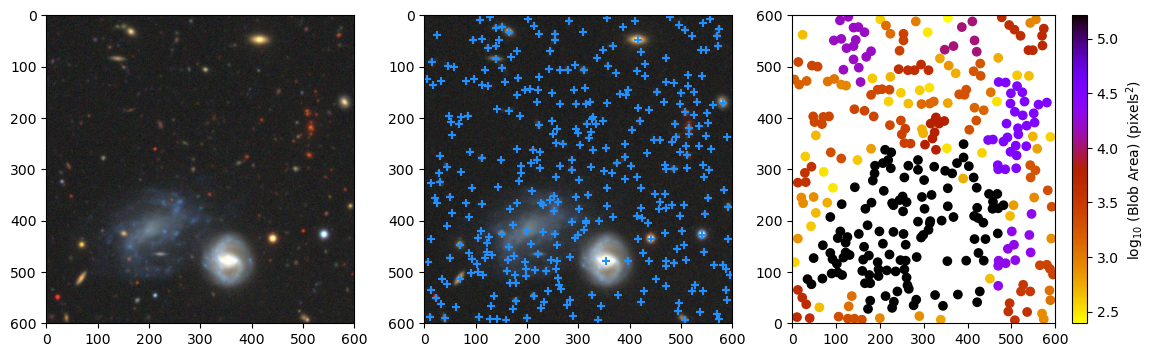

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))#, sharey=True)
img = plt.imread(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image.jpg')
ax[0].imshow(img)
ax[1].imshow(img)
for src in srcs:
    ax[1].scatter(src['ibx'], 600-src['iby'], marker='+', color='dodgerblue')
#plt.scatter(srcs['ra'], srcs['dec'])
S = ax[2].scatter(srcs['ibx'], srcs['iby'], c=blobarea, cmap='gnuplot_r')
ax[0].set_ylim(600, 0)
ax[1].set_ylim(600, 0)
ax[2].set_ylim(0, 600)
for xx in ax:
    xx.set_xlim(0, 600)
plt.colorbar(S, label=r'$\log_{10}\,$(Blob Area) (pixels$^{2}$)')
fig.subplots_adjust(wspace=0.15)